# Image Captioning with LSTMs
In the previous exercise you implemented a vanilla RNN and applied it to image captioning. In this notebook you will implement the LSTM update rule and use it for image captioning.

In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

/home/ismail/anaconda2/envs/deep/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load MS-COCO data
As in the previous notebook, we will use the Microsoft COCO dataset for captioning.

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.iteritems():
  if type(v) == np.ndarray:
    print k, type(v), v.shape, v.dtype
  else:
    print k, type(v), len(v)

idx_to_word <type 'list'> 1004
train_captions <type 'numpy.ndarray'> (400135, 17) int32
val_captions <type 'numpy.ndarray'> (195954, 17) int32
train_image_idxs <type 'numpy.ndarray'> (400135,) int32
val_features <type 'numpy.ndarray'> (40504, 512) float32
val_image_idxs <type 'numpy.ndarray'> (195954,) int32
train_features <type 'numpy.ndarray'> (82783, 512) float32
train_urls <type 'numpy.ndarray'> (82783,) |S63
val_urls <type 'numpy.ndarray'> (40504,) |S63
word_to_idx <type 'dict'> 1004


# LSTM
If you read recent papers, you'll see that many people use a variant on the vanialla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradiants caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task.

# LSTM: step forward
Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function in the file `cs231n/rnn_layers.py`. This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors around `1e-8` or less.

In [3]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print 'next_h error: ', rel_error(expected_next_h, next_h)
print 'next_c error: ', rel_error(expected_next_c, next_c)

next_h error:  5.7054131967097955e-09
next_c error:  5.8143123088804145e-09


#LSTM: step backward
Implement the backward pass for a single LSTM timestep in the function `lstm_step_backward` in the file `cs231n/rnn_layers.py`. Once you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-8` or less.

In [4]:
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print 'dx error: ', rel_error(dx_num, dx)
print 'dh error: ', rel_error(dh_num, dh)
print 'dc error: ', rel_error(dc_num, dc)
print 'dWx error: ', rel_error(dWx_num, dWx)
print 'dWh error: ', rel_error(dWh_num, dWh)
print 'db error: ', rel_error(db_num, db)

dx error:  8.61513949147648e-11
dh error:  3.172674525596687e-10
dc error:  2.948132465476972e-10
dWx error:  1.896839673318675e-08
dWh error:  2.1369659887143427e-08
db error:  3.8469654781297573e-10


# LSTM: forward
In the function `lstm_forward` in the file `cs231n/rnn_layers.py`, implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

When you are done run the following to check your implementation. You should see an error around `1e-7`.

In [5]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print 'h error: ', rel_error(expected_h, h)

h error:  8.610537452106624e-08


# LSTM: backward
Implement the backward pass for an LSTM over an entire timeseries of data in the function `lstm_backward` in the file `cs231n/rnn_layers.py`. When you are done run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-8` or less.

In [6]:
from cs231n.rnn_layers import lstm_forward, lstm_backward

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print 'dx error: ', rel_error(dx_num, dx)
print 'dh0 error: ', rel_error(dh0_num, dh0)
print 'dWx error: ', rel_error(dWx_num, dWx)
print 'dWh error: ', rel_error(dWh_num, dWh)
print 'db error: ', rel_error(db_num, db)

dx error:  3.0938445252960537e-09
dh0 error:  4.769847424308762e-09
dWx error:  1.427700870345698e-08
dWh error:  8.538384475495273e-08
db error:  3.903274839806798e-10


#LSTM captioning model
Now that you have implemented an LSTM, update the implementation of the `loss` method of the `CaptioningRNN` class in the file `cs231n/classifiers/rnn.py` to handle the case where `self.cell_type` is `lstm`. This should require adding less than 10 lines of code.

Once you have done so, run the following to check your implementation. You should see a difference of less than `1e-10`.

In [7]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.iteritems():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print 'loss: ', loss
print 'expected loss: ', expected_loss
print 'difference: ', abs(loss - expected_loss)

loss:  9.82445935443226
expected loss:  9.82445935443
difference:  2.261302256556519e-12


# Overfit LSTM captioning model
Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN above.

cs231n/optim.py:77: RuntimeWarning: invalid value encountered in sqrt
  x -= alpha * (m / (np.sqrt(v) + eps))


(Iteration 1 / 100) loss: 80.675941


(Iteration 11 / 100) loss: 39.698083


(Iteration 21 / 100) loss: 26.405564


(Iteration 31 / 100) loss: 14.185640


(Iteration 41 / 100) loss: 7.608516


(Iteration 51 / 100) loss: 3.554904


(Iteration 61 / 100) loss: 1.534795


(Iteration 71 / 100) loss: 0.502800


(Iteration 81 / 100) loss: 0.249622


(Iteration 91 / 100) loss: 0.163915


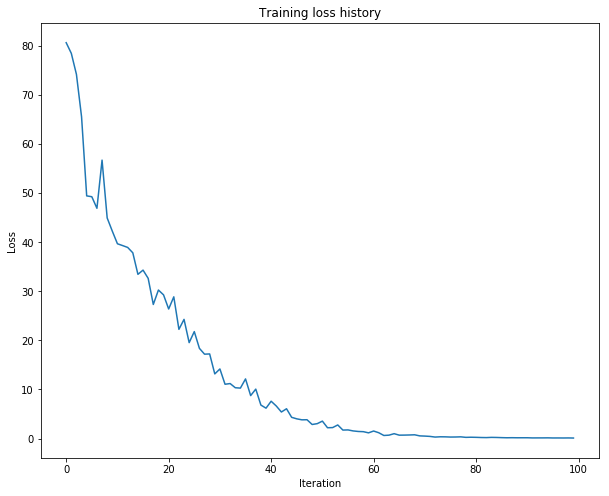

In [8]:
small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# LSTM test-time sampling
Modify the `sample` method of the `CaptioningRNN` class to handle the case where `self.cell_type` is `lstm`. This should take fewer than 10 lines of code.

When you are done run the following to sample from your overfit LSTM model on some training and validation set samples.

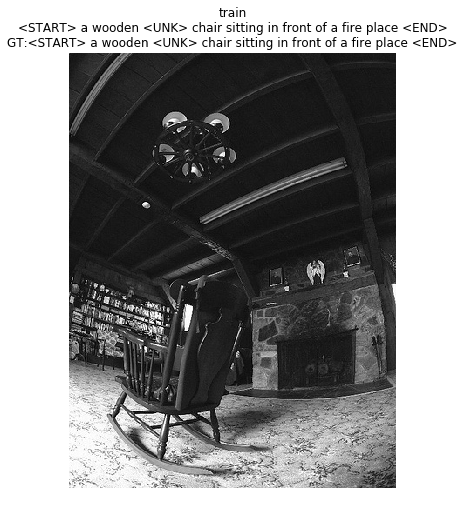

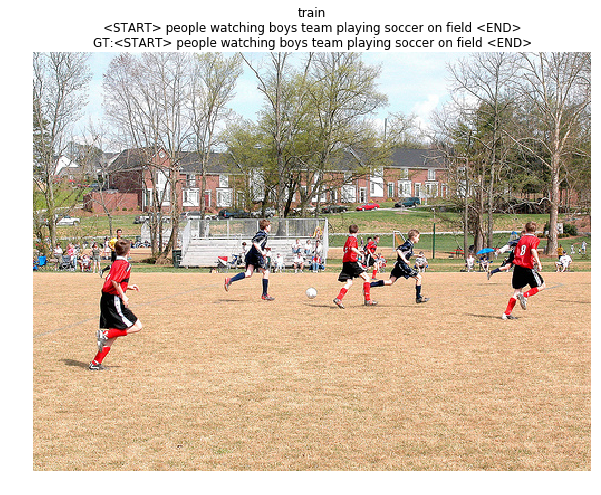

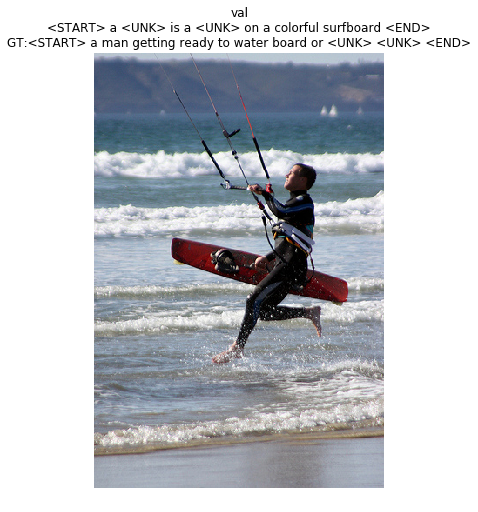

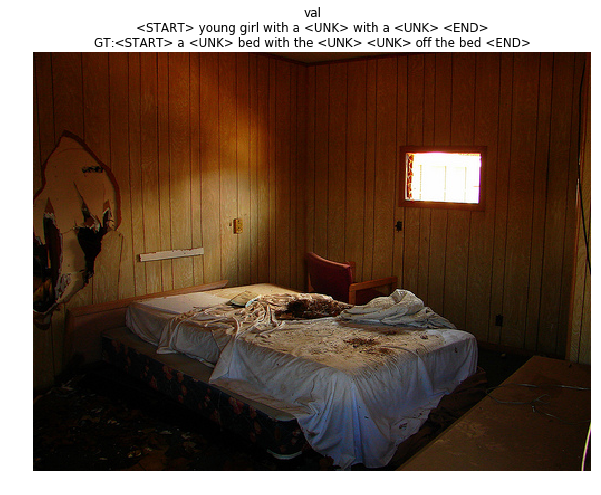

In [9]:
for split in ['train', 'val']:
  minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
  gt_captions, features, urls = minibatch
  gt_captions = decode_captions(gt_captions, data['idx_to_word'])

  sample_captions = small_lstm_model.sample(features)
  sample_captions = decode_captions(sample_captions, data['idx_to_word'])

  for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
    plt.imshow(image_from_url(url))
    plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
    plt.axis('off')
    plt.show()

# Train a good captioning model!
Using the pieces you have implemented in this and the previous notebook, try to train a captioning model that gives decent qualitative results (better than the random garbage you saw with the overfit models) when sampling on the validation set. You can subsample the training set if you want; we just want to see samples on the validatation set that are better than random.

Don't spend too much time on this part; we don't have any explicit accuracy thresholds you need to meet.

In [10]:
train_data = load_coco_data(max_train=5000)

lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

lstm_solver = CaptioningSolver(lstm_model, train_data,
           update_rule='adam',
           num_epochs=10,
           batch_size=25,
           optim_config={
             'learning_rate': 1e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

lstm_solver.train()

(Iteration 1 / 2000) loss: 73.872215


(Iteration 11 / 2000) loss: 76.088781


(Iteration 21 / 2000) loss: 58.328112


(Iteration 31 / 2000) loss: 53.301935


(Iteration 41 / 2000) loss: 55.021995


(Iteration 51 / 2000) loss: 51.442924


(Iteration 61 / 2000) loss: 51.545645


(Iteration 71 / 2000) loss: 49.631948


(Iteration 81 / 2000) loss: 50.044736


(Iteration 91 / 2000) loss: 49.534410


(Iteration 101 / 2000) loss: 47.119484


(Iteration 111 / 2000) loss: 45.620695


(Iteration 121 / 2000) loss: 50.134500


(Iteration 131 / 2000) loss: 45.369831


(Iteration 141 / 2000) loss: 45.133151


(Iteration 151 / 2000) loss: 43.733979


(Iteration 161 / 2000) loss: 40.164831


(Iteration 171 / 2000) loss: 39.944880


(Iteration 181 / 2000) loss: 36.471435


(Iteration 191 / 2000) loss: 37.403020


(Iteration 201 / 2000) loss: 39.701588


(Iteration 211 / 2000) loss: 40.530393


(Iteration 221 / 2000) loss: 36.669629


(Iteration 231 / 2000) loss: 37.749021


(Iteration 241 / 2000) loss: 37.290444


(Iteration 251 / 2000) loss: 34.647669


(Iteration 261 / 2000) loss: 35.225659


(Iteration 271 / 2000) loss: 36.937785


(Iteration 281 / 2000) loss: 33.851490


(Iteration 291 / 2000) loss: 38.229868


(Iteration 301 / 2000) loss: 35.124555


(Iteration 311 / 2000) loss: 32.719909


(Iteration 321 / 2000) loss: 35.308766


(Iteration 331 / 2000) loss: 33.163619


(Iteration 341 / 2000) loss: 35.629950


(Iteration 351 / 2000) loss: 35.742511


(Iteration 361 / 2000) loss: 36.248563


(Iteration 371 / 2000) loss: 33.150333


(Iteration 381 / 2000) loss: 32.424354


(Iteration 391 / 2000) loss: 35.599586


(Iteration 401 / 2000) loss: 37.629336


(Iteration 411 / 2000) loss: 29.613213


(Iteration 421 / 2000) loss: 31.951097


(Iteration 431 / 2000) loss: 32.063453


(Iteration 441 / 2000) loss: 29.551700


(Iteration 451 / 2000) loss: 31.385310


(Iteration 461 / 2000) loss: 30.807735


(Iteration 471 / 2000) loss: 30.601170


(Iteration 481 / 2000) loss: 30.318517


(Iteration 491 / 2000) loss: 33.161444


(Iteration 501 / 2000) loss: 30.844834


(Iteration 511 / 2000) loss: 29.842756


(Iteration 521 / 2000) loss: 31.590437


(Iteration 531 / 2000) loss: 30.122794


(Iteration 541 / 2000) loss: 30.827579


(Iteration 551 / 2000) loss: 31.003727


(Iteration 561 / 2000) loss: 28.051430


(Iteration 571 / 2000) loss: 30.768582


(Iteration 581 / 2000) loss: 32.722967


(Iteration 591 / 2000) loss: 27.739814


(Iteration 601 / 2000) loss: 31.553968


(Iteration 611 / 2000) loss: 30.534829


(Iteration 621 / 2000) loss: 32.686026


(Iteration 631 / 2000) loss: 33.126345


(Iteration 641 / 2000) loss: 28.316077


(Iteration 651 / 2000) loss: 28.139922


(Iteration 661 / 2000) loss: 27.674746


(Iteration 671 / 2000) loss: 26.223118


(Iteration 681 / 2000) loss: 26.738219


(Iteration 691 / 2000) loss: 27.785098


(Iteration 701 / 2000) loss: 25.952855


(Iteration 711 / 2000) loss: 25.710097


(Iteration 721 / 2000) loss: 30.008044


(Iteration 731 / 2000) loss: 28.486895


(Iteration 741 / 2000) loss: 25.498970


(Iteration 751 / 2000) loss: 27.277458


(Iteration 761 / 2000) loss: 23.502799


(Iteration 771 / 2000) loss: 24.567783


(Iteration 781 / 2000) loss: 25.372574


(Iteration 791 / 2000) loss: 25.983966


(Iteration 801 / 2000) loss: 28.003176


(Iteration 811 / 2000) loss: 24.241894


(Iteration 821 / 2000) loss: 22.544959


(Iteration 831 / 2000) loss: 30.239329


(Iteration 841 / 2000) loss: 28.914725


(Iteration 851 / 2000) loss: 24.103856


(Iteration 861 / 2000) loss: 25.584043


(Iteration 871 / 2000) loss: 22.752929


(Iteration 881 / 2000) loss: 27.154316


(Iteration 891 / 2000) loss: 22.023740


(Iteration 901 / 2000) loss: 23.979351


(Iteration 911 / 2000) loss: 23.129292


(Iteration 921 / 2000) loss: 20.240593


(Iteration 931 / 2000) loss: 24.419768


(Iteration 941 / 2000) loss: 25.834835


(Iteration 951 / 2000) loss: 27.278548


(Iteration 961 / 2000) loss: 27.930318


(Iteration 971 / 2000) loss: 21.922405


(Iteration 981 / 2000) loss: 27.118532


(Iteration 991 / 2000) loss: 22.388050


(Iteration 1001 / 2000) loss: 24.837028


(Iteration 1011 / 2000) loss: 22.000201


(Iteration 1021 / 2000) loss: 21.193438


(Iteration 1031 / 2000) loss: 25.579957


(Iteration 1041 / 2000) loss: 24.087650


(Iteration 1051 / 2000) loss: 21.006945


(Iteration 1061 / 2000) loss: 23.989523


(Iteration 1071 / 2000) loss: 22.122002


(Iteration 1081 / 2000) loss: 19.516092


(Iteration 1091 / 2000) loss: 21.984790


(Iteration 1101 / 2000) loss: 22.259803


(Iteration 1111 / 2000) loss: 21.638117


(Iteration 1121 / 2000) loss: 23.282352


(Iteration 1131 / 2000) loss: 21.024128


(Iteration 1141 / 2000) loss: 23.687430


(Iteration 1151 / 2000) loss: 17.269439


(Iteration 1161 / 2000) loss: 18.654866


(Iteration 1171 / 2000) loss: 18.911646


(Iteration 1181 / 2000) loss: 24.167071


(Iteration 1191 / 2000) loss: 19.641434


(Iteration 1201 / 2000) loss: 19.422487


(Iteration 1211 / 2000) loss: 20.332243


(Iteration 1221 / 2000) loss: 24.698093


(Iteration 1231 / 2000) loss: 19.636619


(Iteration 1241 / 2000) loss: 19.224118


(Iteration 1251 / 2000) loss: 20.187484


(Iteration 1261 / 2000) loss: 16.512137


(Iteration 1271 / 2000) loss: 23.806785


(Iteration 1281 / 2000) loss: 17.663807


(Iteration 1291 / 2000) loss: 18.120643


(Iteration 1301 / 2000) loss: 18.224677


(Iteration 1311 / 2000) loss: 22.629457


(Iteration 1321 / 2000) loss: 18.778569


(Iteration 1331 / 2000) loss: 20.786878


(Iteration 1341 / 2000) loss: 22.015282


(Iteration 1351 / 2000) loss: 18.280627


(Iteration 1361 / 2000) loss: 16.909686


(Iteration 1371 / 2000) loss: 17.510135


(Iteration 1381 / 2000) loss: 18.259419


(Iteration 1391 / 2000) loss: 20.931561


(Iteration 1401 / 2000) loss: 16.795740


(Iteration 1411 / 2000) loss: 16.965801


(Iteration 1421 / 2000) loss: 17.143911


(Iteration 1431 / 2000) loss: 15.610065


(Iteration 1441 / 2000) loss: 17.982487


(Iteration 1451 / 2000) loss: 16.208930


(Iteration 1461 / 2000) loss: 16.107688


(Iteration 1471 / 2000) loss: 17.731434


(Iteration 1481 / 2000) loss: 19.912730


(Iteration 1491 / 2000) loss: 13.558803


(Iteration 1501 / 2000) loss: 18.918213


(Iteration 1511 / 2000) loss: 14.287966


(Iteration 1521 / 2000) loss: 15.298155


(Iteration 1531 / 2000) loss: 19.232873


(Iteration 1541 / 2000) loss: 21.672607


(Iteration 1551 / 2000) loss: 20.425416


(Iteration 1561 / 2000) loss: 18.642208


(Iteration 1571 / 2000) loss: 16.394037


(Iteration 1581 / 2000) loss: 19.367489


(Iteration 1591 / 2000) loss: 16.565872


(Iteration 1601 / 2000) loss: 17.283093


(Iteration 1611 / 2000) loss: 14.168753


(Iteration 1621 / 2000) loss: 16.065054


(Iteration 1631 / 2000) loss: 20.327723


(Iteration 1641 / 2000) loss: 15.146656


(Iteration 1651 / 2000) loss: 15.804106


(Iteration 1661 / 2000) loss: 17.550192


(Iteration 1671 / 2000) loss: 16.860198


(Iteration 1681 / 2000) loss: 16.455814


(Iteration 1691 / 2000) loss: 15.214110


(Iteration 1701 / 2000) loss: 11.288279


(Iteration 1711 / 2000) loss: 16.853294


(Iteration 1721 / 2000) loss: 12.637424


(Iteration 1731 / 2000) loss: 12.948143


(Iteration 1741 / 2000) loss: 14.337212


(Iteration 1751 / 2000) loss: 13.053777


(Iteration 1761 / 2000) loss: 14.378314


(Iteration 1771 / 2000) loss: 14.817452


(Iteration 1781 / 2000) loss: 14.981378


(Iteration 1791 / 2000) loss: 15.776495


(Iteration 1801 / 2000) loss: 13.021181


(Iteration 1811 / 2000) loss: 15.984192


(Iteration 1821 / 2000) loss: 13.033665


(Iteration 1831 / 2000) loss: 15.658859


(Iteration 1841 / 2000) loss: 14.633411


(Iteration 1851 / 2000) loss: 13.141971


(Iteration 1861 / 2000) loss: 13.505903


(Iteration 1871 / 2000) loss: 13.575110


(Iteration 1881 / 2000) loss: 12.193680


(Iteration 1891 / 2000) loss: 14.437072


(Iteration 1901 / 2000) loss: 11.128270


(Iteration 1911 / 2000) loss: 14.231020


(Iteration 1921 / 2000) loss: 12.710924


(Iteration 1931 / 2000) loss: 11.930851


(Iteration 1941 / 2000) loss: 12.007533


(Iteration 1951 / 2000) loss: 11.466780


(Iteration 1961 / 2000) loss: 12.586874


(Iteration 1971 / 2000) loss: 13.178421


(Iteration 1981 / 2000) loss: 11.799808


(Iteration 1991 / 2000) loss: 13.765567


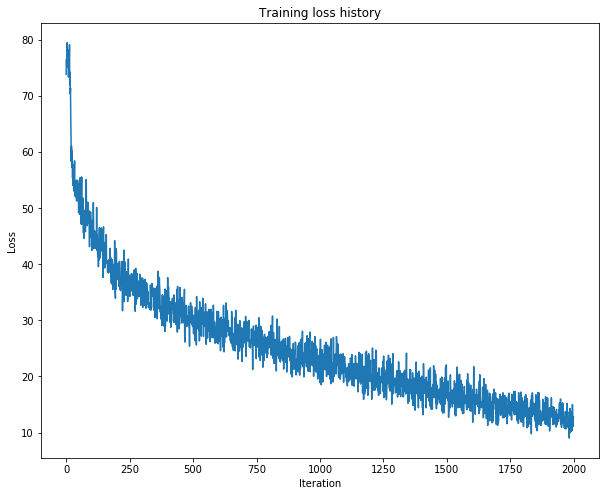

In [11]:
# Plot the training losses
plt.plot(lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

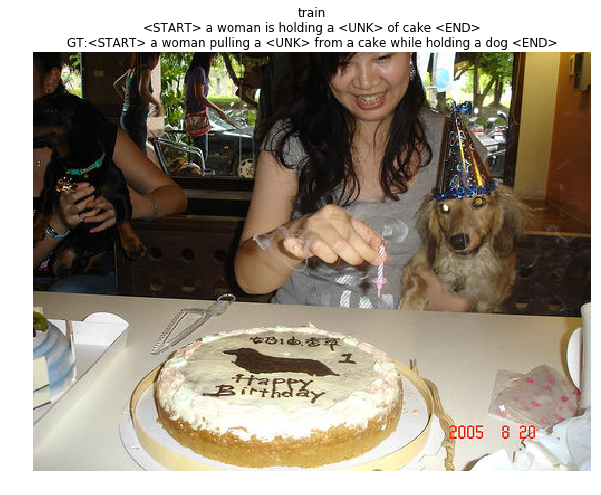

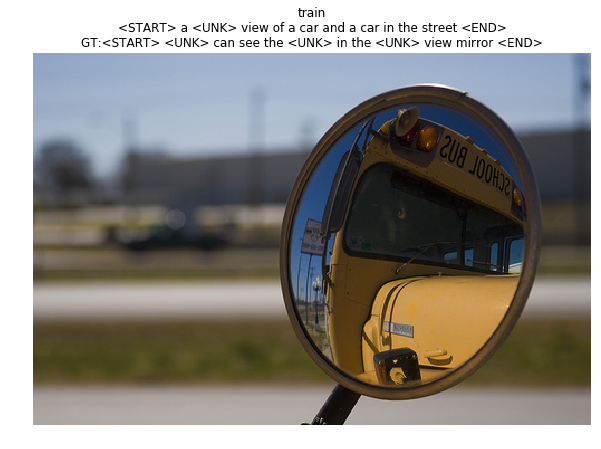

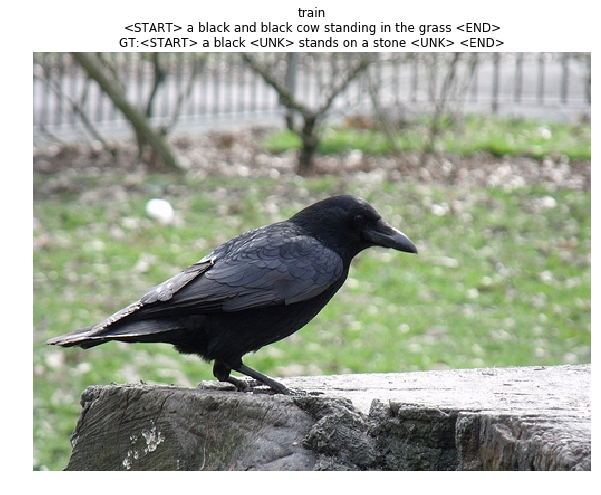

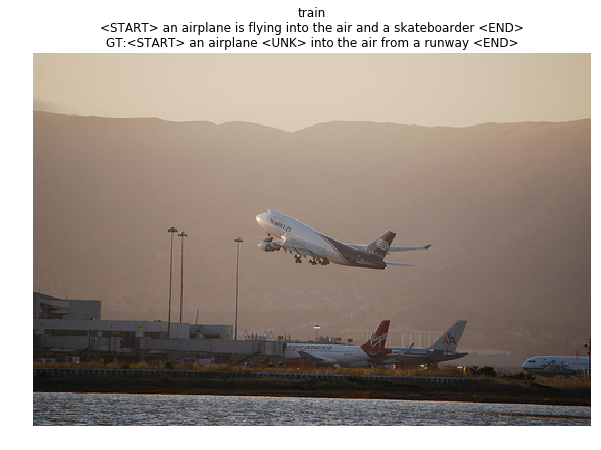

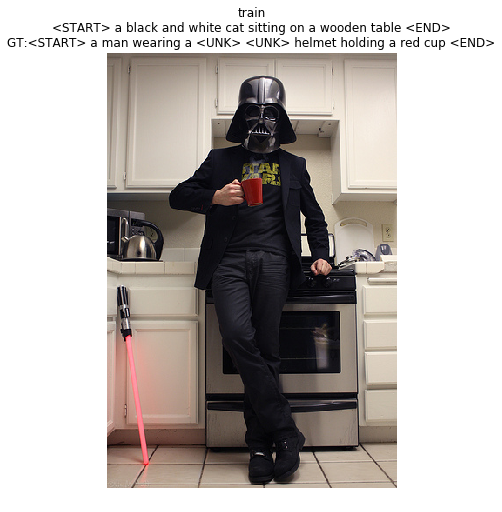

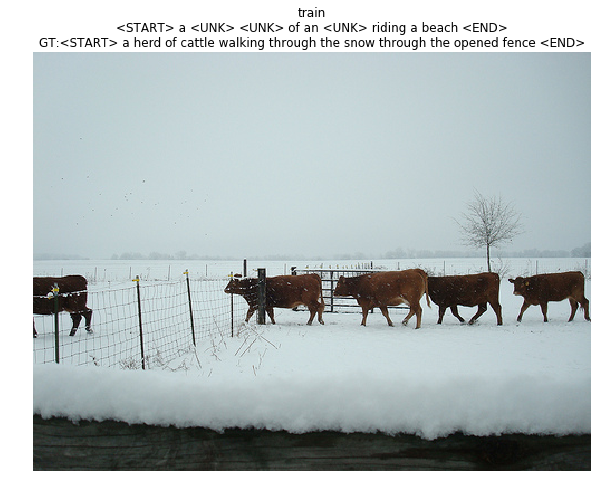

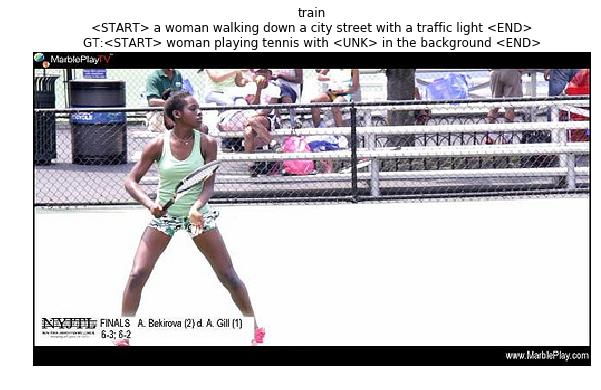

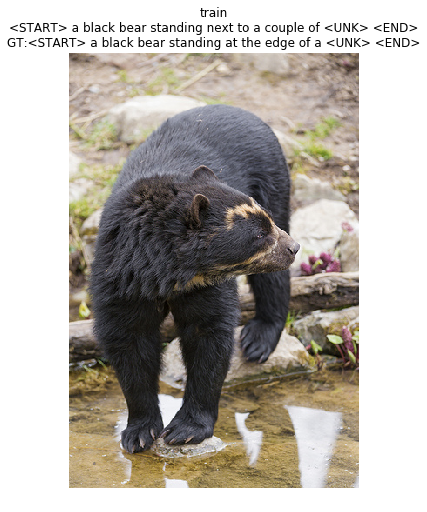

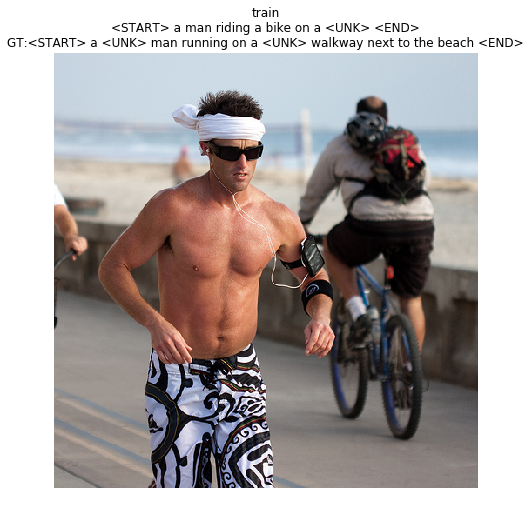

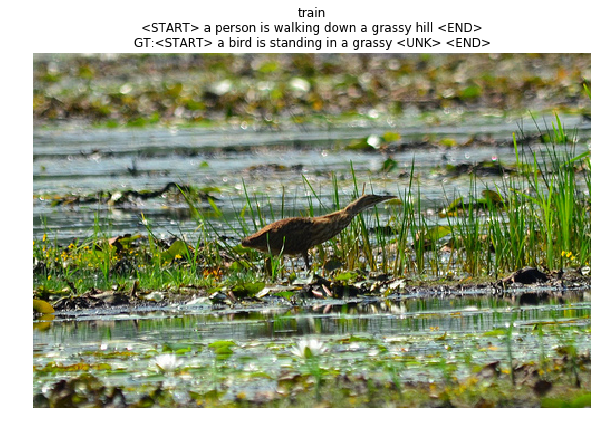

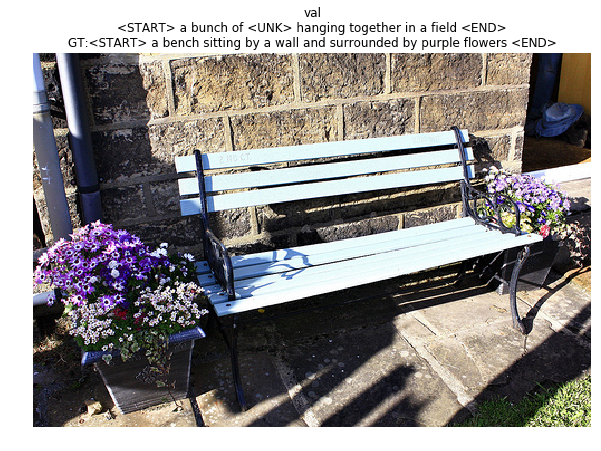

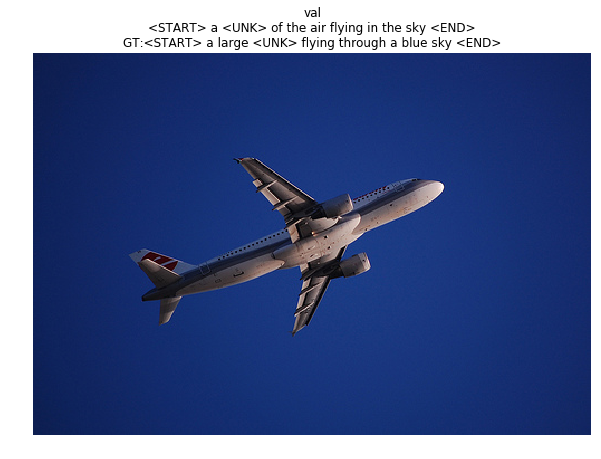

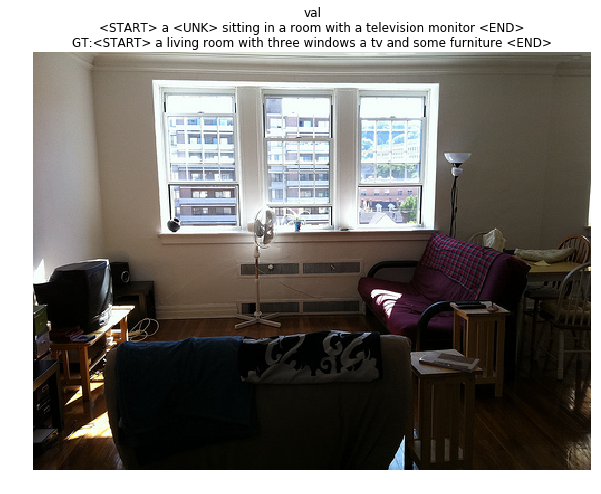

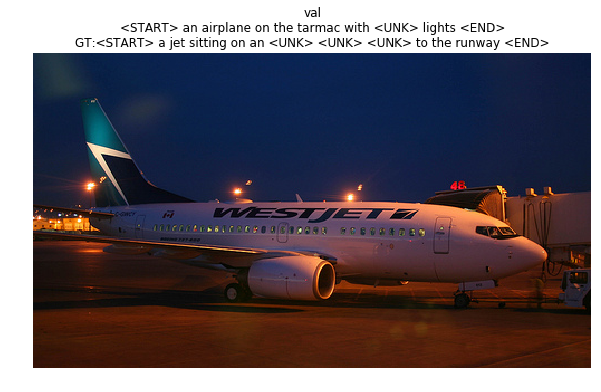

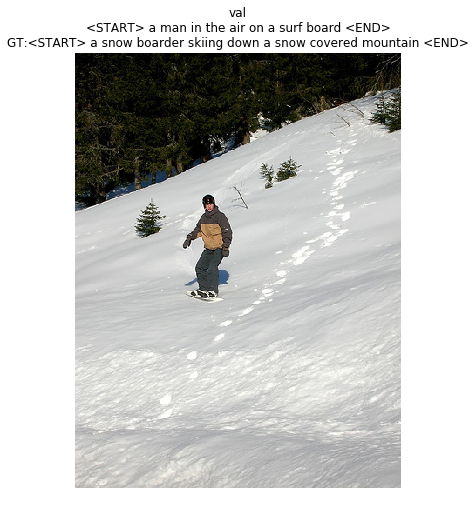

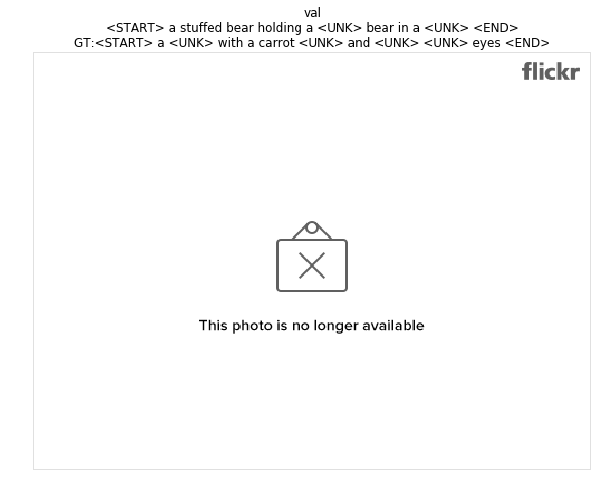

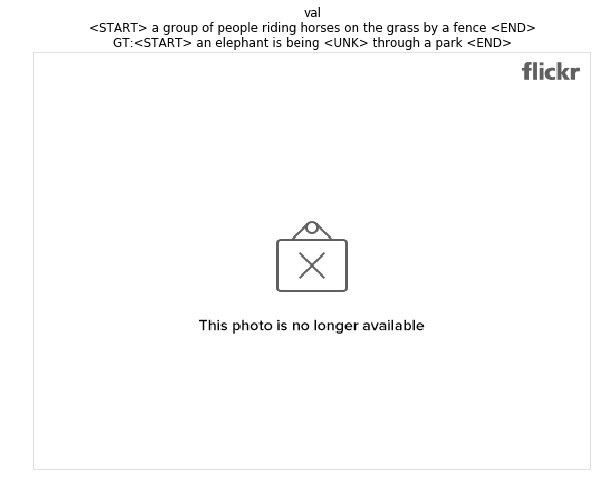

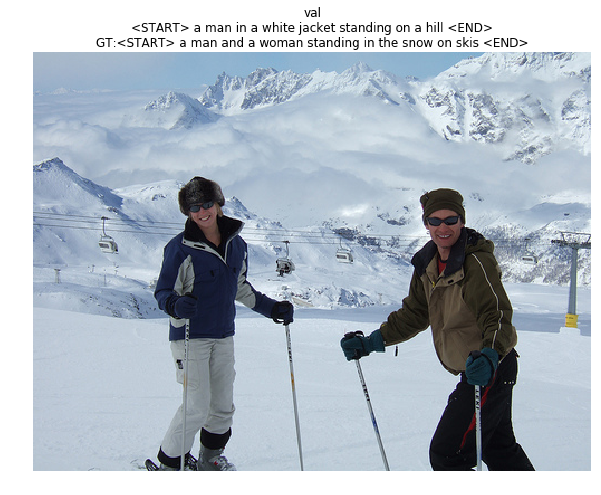

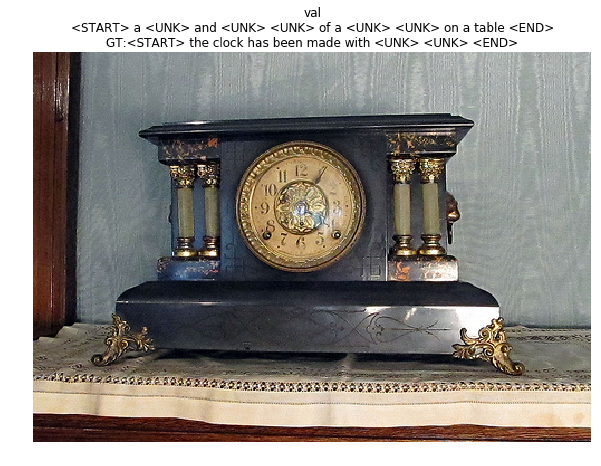

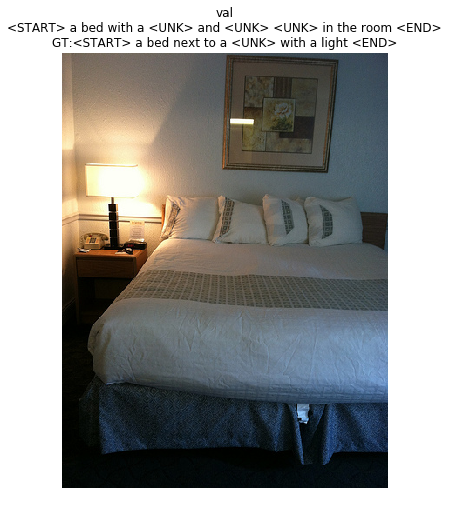

In [12]:
for split in ['train', 'val']:
  minibatch = sample_coco_minibatch(train_data, split=split, batch_size=10)
  gt_captions, features, urls = minibatch
  gt_captions = decode_captions(gt_captions, data['idx_to_word'])

  sample_captions = lstm_model.sample(features)
  sample_captions = decode_captions(sample_captions, data['idx_to_word'])

  for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
    plt.imshow(image_from_url(url))
    plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
    plt.axis('off')
    plt.show()